# Tarea 2: Máquina de Vectores Soporte

Para esta tarea vamos a trabajar con el dataset [healthcare-dataset-stroke-data](https://https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download). Con este dataset trataremos de resolver un problema de **clasificación**, en el cual nuestro target es si el paciente tiene o no un derrame cerebral (**stroke**). En la primera tarea ya realizamos un **análisis descriptivo y exploratorio** de los datos, también un **preprocesamiento** de los mismos. Después abordaremos nuestra tarea de clasificación mediante el uso de un **SVM lineal**. Además, aplicaremos un **SVM no lineal** por si solo y , aplicando **métodos wrapper** de selección de características. Por último compararemos resultados con los modelos de todos los apartados, incluyendo la tarea 1y elegiremos un modelo de esta tarea como el mejor.

### Carga de datos


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.metrics import make_scorer
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV

from sklearn.metrics import (classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay)
warnings.filterwarnings(action='ignore')

Como en la primera tarea ya hicimos preprocesado, importamos los csv de dicha tarea. Se imputaron valores faltantes mediante knn, se aplicó una transformación logarítmica a aquellas variables con colas muy largas, se hizo un escalado de los datos para poder usarlos en los modelos y se utilizó one-hot encoding para las variables categóricas.

In [3]:
X_train = pd.read_csv('X_train_resampled.csv')
y_train = pd.read_csv('y_train_resampled.csv')
X_val = pd.read_csv('X_val_prep.csv')
y_val = pd.read_csv('y_val.csv')
x_test = pd.read_csv('x_test_prep.csv')
y_test = pd.read_csv('y_test.csv')

In [4]:
def get_metrics(y_true, y_pred, model_name):
    return {
        "Modelo": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred, average='weighted'),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted')
    }

### Sección I: Esquema Lineal


En vez de volver a entrenar el modelo de regresión logística de la tarea 1 en esta tarea, lo guardamos utilizando pickle y lo importamos aqui.

In [5]:
nombre_archivo_modelo = 'logistic_regression_smote.pkl'
with open(nombre_archivo_modelo, 'rb') as f:
    log_reg = pickle.load(f)

Vamos a buscar mediante cross validation los mejores hiperparámetros del modelo SVM lineal

In [6]:
# Entrenamos el SVM buscando el mejor c
param_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}
grid_linear = GridSearchCV(SVC(random_state=42), param_grid_linear, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_linear.fit(X_train, y_train)
best_svm_linear = grid_linear.best_estimator_
print(f"Mejor C para SVM lineal: {grid_linear.best_params_['C']}")



Mejor C para SVM lineal: 100


Vamos a visualizar los coeficientes del modelo y a compararlos con los del modelo logístico de la tarea 1

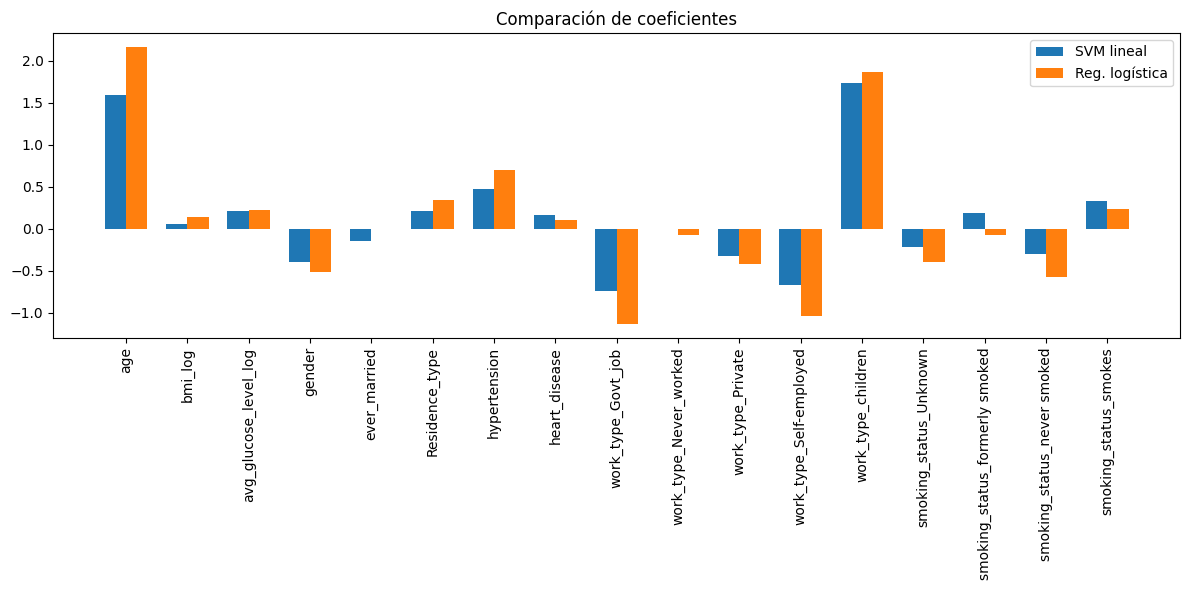

In [7]:
# Comparamos coeficientes de los modelos
coefs_log = log_reg.coef_[0]
coefs_svm = best_svm_linear.coef_[0]

plt.figure(figsize=(12, 6))
indices = np.arange(len(X_train.columns))
width = 0.35
plt.bar(indices - width/2, coefs_svm, width, label='SVM lineal', color='#1f77b4')
plt.bar(indices + width/2, coefs_log, width, label='Reg. logística', color='#ff7f0e')
plt.xticks(indices, X_train.columns, rotation=90)
plt.title("Comparación de coeficientes")
plt.legend()
plt.tight_layout()
plt.show()


Como se puede ver, ambos modelos hacen un énfasis parecido (en cuanto a proporciones) en cada una de las variables, aunque si que hay diferencias en los valores de los parámetros. Por ejemplo, la regresión logística da más peso a la edad, pero no tiene en cuenta si el paciente estuvo casado.

In [8]:
# Figuras de mérito de cada modelo
metrics_t1 = get_metrics(y_val, log_reg.predict(X_val), "Reg. logística")
metrics_lin = get_metrics(y_val, best_svm_linear.predict(X_val), "SVM lineal")

all_metrics = [metrics_t1, metrics_lin]

df_comparacion_1 = pd.DataFrame(all_metrics)
df_comparacion_1.set_index('Modelo', inplace=True)

display(df_comparacion_1)


,Accuracy,F1-Score,Precision,Recall
Modelo,,,,
Reg. logística,0.738748,0.812674,0.943154,0.738748
SVM lineal,0.722114,0.801052,0.943875,0.722114


Si comparamos las figuras de mérito de la regresión logística con la del svm lineal, podemos ver como son bastante similares

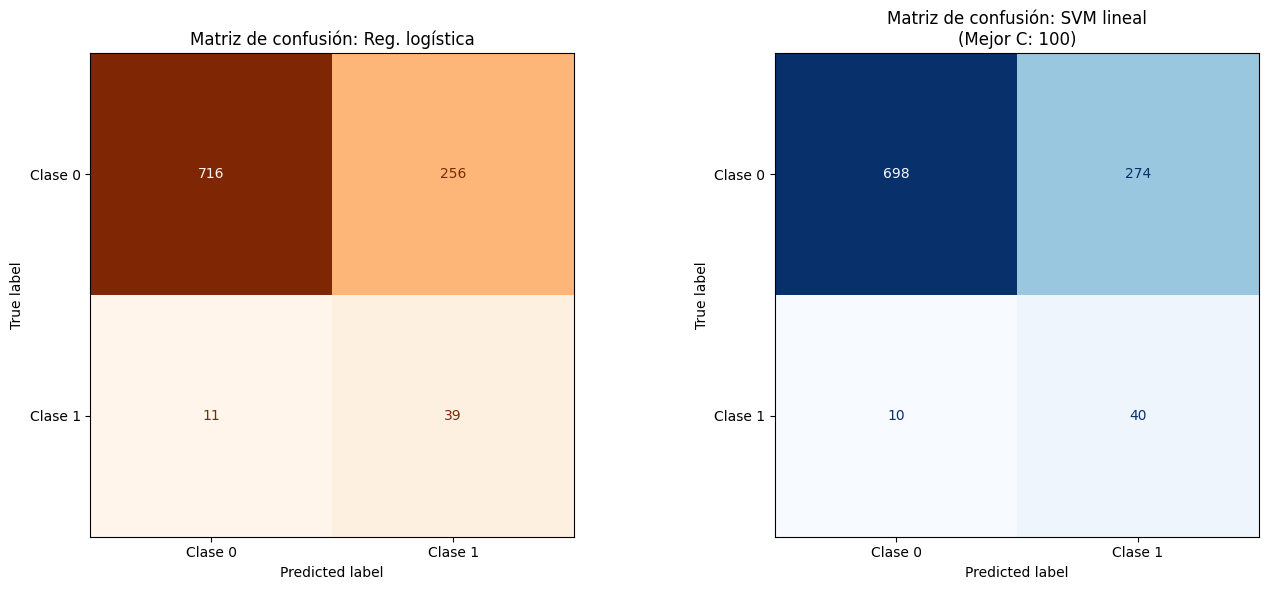

In [9]:
y_pred_log = log_reg.predict(X_val)
y_pred_svm = best_svm_linear.predict(X_val)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_log = confusion_matrix(y_val, y_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['Clase 0', 'Clase 1'])
disp_log.plot(ax=axes[0], cmap='Oranges', colorbar=False)
axes[0].set_title('Matriz de confusión: Reg. logística')

cm_svm = confusion_matrix(y_val, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Clase 0', 'Clase 1'])
disp_svm.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title(f"Matriz de confusión: SVM lineal\n(Mejor C: {grid_linear.best_params_['C']})")

plt.tight_layout()
plt.show()

De nuevo vemos lo mismo, los resultados son bastante similares, aunque el SVM lineal comete bastantes más errores al predecir 0s, dando lugar a un incremento de alrededor de un 8% en los casos de falsos positivos

### Sección II: Esquema No Lineal y Wrapper


#### Modelo no lineal

A continuación vamos a hallar el mejor modelo SVM no lineal usando CV y comparando distintos valores de C, gamma y varios tipos de kernel para ver cual nos da un mejor resultado. Para elegir dicho modelo, vamos a utilizar el F1-score ya que nos da un balance entre la recall y la precision que es justo lo que buscamos. Priorizar siempre la recall pero buscando minimizar el numero de falsos positivos, que en casos clínicos podrían hacer que el sistema colapsarra.

In [10]:
param_grid_nonlinear = [
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.01, 0.1, 1]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3], 'gamma': ['scale']},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10], 'gamma': ['scale', 0.1], 'coef0': [0]}
]

grid_nl = GridSearchCV(
    estimator=SVC(class_weight='balanced', random_state=42),
    param_grid=param_grid_nonlinear,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_nl.fit(X_train, y_train)

best_params_nl = grid_nl.best_params_
best_model_nl = grid_nl.best_estimator_

print(f"   Mejor Modelo: {best_params_nl['kernel'].upper()}")
print(f"   Parámetros: {best_params_nl}")
print(f"   Mejor F1-score: {grid_nl.best_score_}")

   Mejor Modelo: RBF
   Parámetros: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
   Mejor F1-score: 0.975305224479056


Como podemos ver, el mejor modelo usa el kernel RBF con parametros C=10 y gamma = 1.
Vamos a visualizar el endimiento de cada uno de los kernels y la evolucion del kernel ganador para entender el por qué se ha elegido dicha combinación.

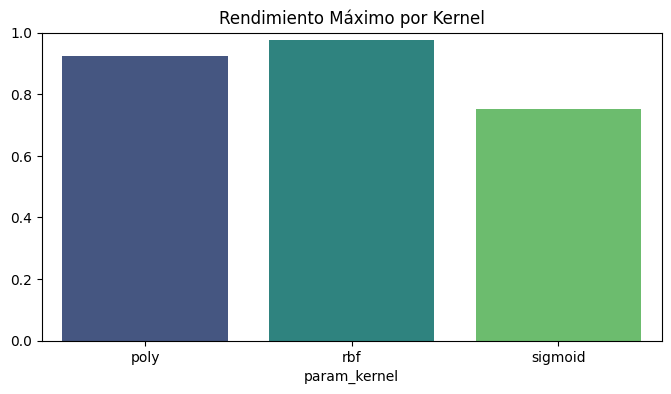

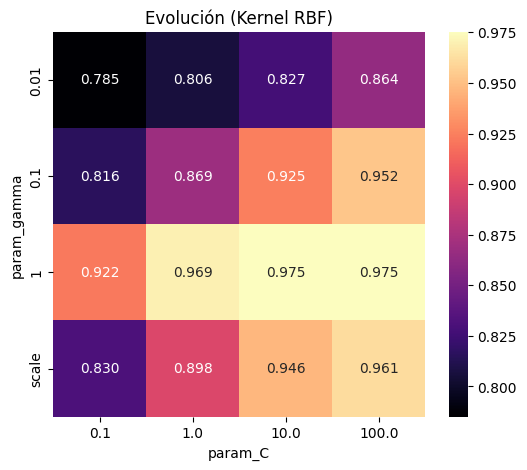

In [11]:
results_df = pd.DataFrame(grid_nl.cv_results_)

plt.figure(figsize=(8, 4))
sns.barplot(x=results_df.groupby('param_kernel')['mean_test_score'].max().index, y=results_df.groupby('param_kernel')['mean_test_score'].max().values, palette='viridis')
plt.title("Rendimiento Máximo por Kernel")
plt.ylim(0, 1.0)
plt.show()

if best_params_nl['kernel'] == 'rbf':
    subset = results_df[results_df['param_kernel'] == 'rbf'].copy()
    subset['param_gamma'] = subset['param_gamma'].astype(str)
    heatmap_data = subset.pivot_table(values='mean_test_score', index='param_gamma', columns='param_C')
    plt.figure(figsize=(6, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='magma')
    plt.title("Evolución (Kernel RBF)")
    plt.show()


Como se trata de un modelo no lineal, los coefiicientes no tienen una explicabilidad concreta. Por ello, hemos evaluado la permutation importance, que nos muestra la variación del F1-score al permutar las variables, dandonos una suerte de importancia de las variables.

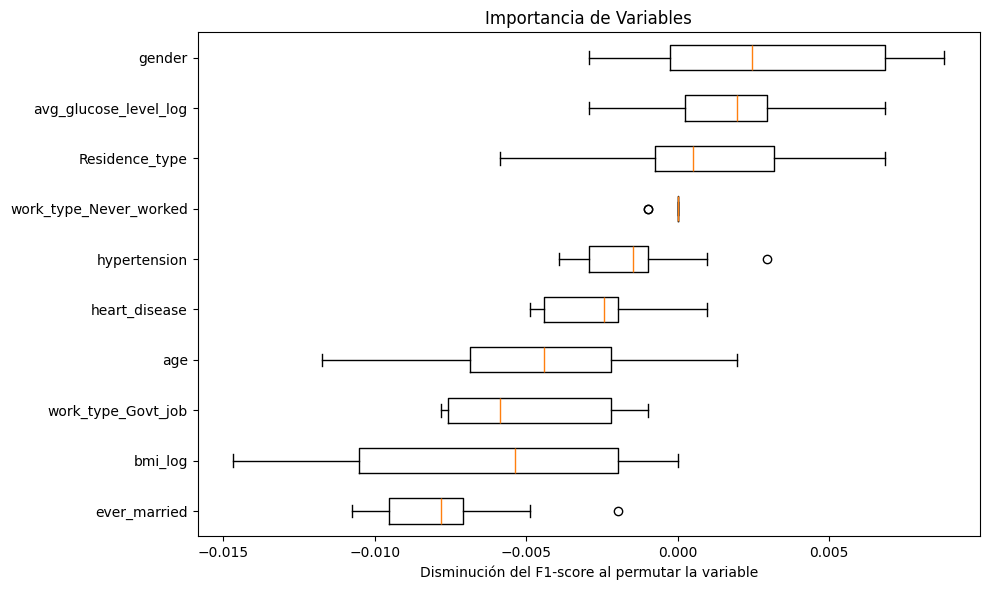

In [12]:
result = permutation_importance(best_model_nl, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()[-10:]
plt.figure(figsize=(10, 6))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_val.columns[sorted_idx]
)
plt.title("Importancia de Variables")
plt.xlabel("Disminución del F1-score al permutar la variable")
plt.tight_layout()
plt.show()

Por último hacemos la predicción para ver las figuras de mérito y la matriz de confusión

In [13]:
y_pred_nl = best_model_nl.predict(X_val)

print(classification_report(y_val, y_pred_nl))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       972
           1       0.08      0.08      0.08        50

    accuracy                           0.91      1022
   macro avg       0.51      0.52      0.52      1022
weighted avg       0.91      0.91      0.91      1022



Vemos que tanto la recall como el f1-score son muy malos en comparación con el modelo lineal. Esto seguramente se deba a que el modelo no encuentra una buena frontera no lineal y en cambio es mucho más facil separar nuestros datos mediantes una frontera lineal, de ahi el bajo valor de las figuras de mérito de este modelo.

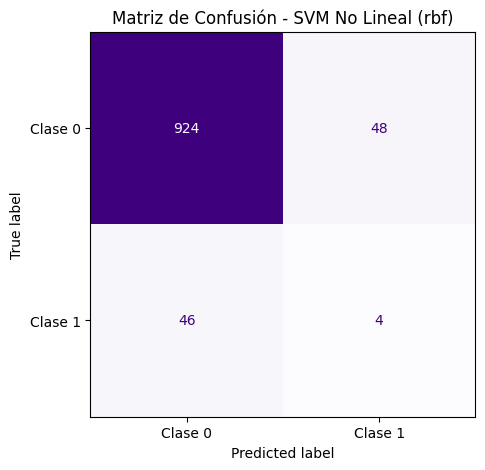

In [14]:
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred_nl)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clase 0', 'Clase 1'])
disp.plot(ax=ax, cmap='Purples', colorbar=False)

ax.set_title(f"Matriz de Confusión - SVM No Lineal ({best_model_nl.kernel})")
plt.show()

Vemos como predice muy mal los verdaderos posiitivos, en cambio todo lo demás lo predice mucho mejor. A pesar de ello, el modelo es mucho peor para nuestro problema ya que debemos priorizar un diagnóstico correcto aunque tengamos algun falso positivo frente a predecir siempre bien los casos mayoritarios (no enfermos) a costa de los casos de personas con riesgo de ictus.

#### Selección de características mediante métodos Wrapper

Al principio intentamos hacerlo con un SVM normal (SVC de sklearn) pero al tener 17 características e intentar entrenar tantísimos modelos, tardaba muchísimo, es por ello que decidi investigar y encontré LinearSVC que utiliza la librerís liblinear que está mucho más optimizada que la que usa SVC y en este caso como se pide usar un SVM para selección de características, sin necesidad de que sea no lineal, podemos utilizar esta funcion.

Número óptimo de características: 15
Variables seleccionadas: ['age', 'bmi_log', 'avg_glucose_level_log', 'gender', 'ever_married', 'Residence_type', 'hypertension', 'heart_disease', 'work_type_Govt_job', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_Unknown', 'smoking_status_never smoked', 'smoking_status_smokes']


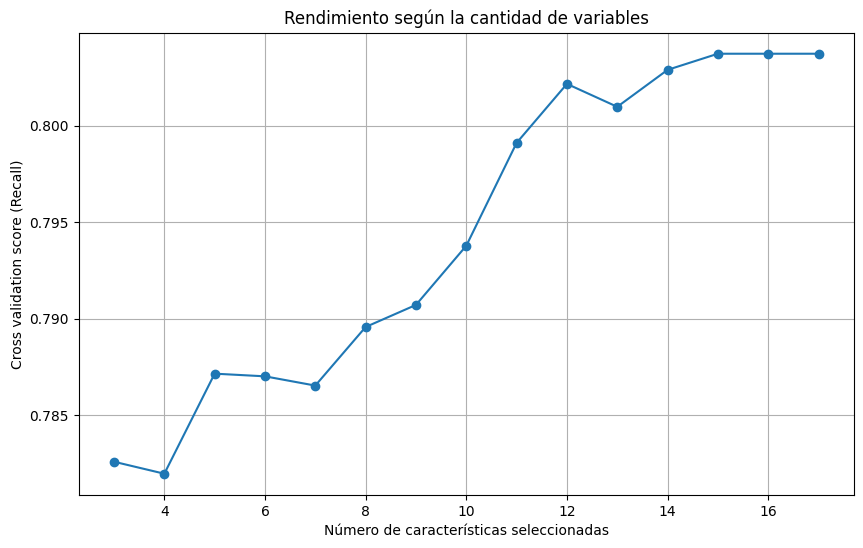

In [15]:
svm_rapido = LinearSVC(class_weight='balanced', dual=False, max_iter=5000, random_state=42)
rfecv = RFECV(
    estimator=svm_rapido,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1_weighted',
    min_features_to_select=3,
    n_jobs=-1
)

rfecv.fit(X_train, y_train)
print(f"Número óptimo de características: {rfecv.n_features_}")
selected_features = X_train.columns[rfecv.support_]
print(f"Variables seleccionadas: {list(selected_features)}")

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize=(10, 6))
plt.xlabel("Número de características seleccionadas")
plt.ylabel("Cross validation score (Recall)")
plt.plot(
    range(rfecv.min_features_to_select, n_scores + rfecv.min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    marker='o'
)
plt.title("Rendimiento según la cantidad de variables")
plt.grid(True)
plt.show()

Podemos ver que se estabiliza definitivamente en 15, pero el resultado de usar 12 variables es prácticamente el mismo y simplifica el modelo bastante. Podríamos usar menos aún ya que las diferencias no son nada grandes pero por robustez hemos elegido usar 12, que además si seguimos el principio de parsimonia, es lo correcto frente a usar 15.

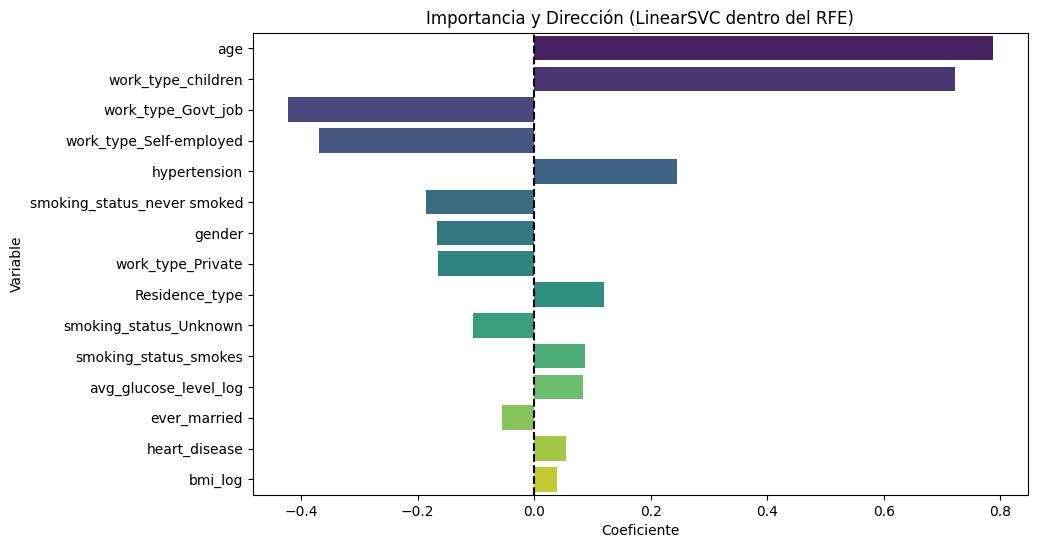

In [16]:

selected_cols = X_train.columns[rfecv.support_]
coefs = rfecv.estimator_.coef_[0]

coef_df = pd.DataFrame({'Variable': selected_cols, 'Coeficiente': coefs})
coef_df['Abs_Coef'] = coef_df['Coeficiente'].abs()
coef_df = coef_df.sort_values(by='Abs_Coef', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coeficiente', y='Variable', palette='viridis')
plt.title("Importancia y Dirección (LinearSVC dentro del RFE)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

Aquí podemos ver la importancia de los coeficientes en el SVM que hemos usado para hacer la selección de características.

Por último, vemos cuales son diichas características y entrenamos el modelo no lineal que habiamos visto que era el óptimo anteriormente, pero ahora con las características seleccionadas.

In [17]:
from sklearn.feature_selection import RFE

rfe_12 = RFE(
    estimator=svm_rapido,
    n_features_to_select=12,
    step=1
)

rfe_12.fit(X_train, y_train)

cols_12 = X_train.columns[rfe_12.support_]
print(f"Las 12 mejores variables son: {list(cols_12)}")

X_train_sel = rfe_12.transform(X_train)
X_val_sel = rfe_12.transform(X_val)

Las 12 mejores variables son: ['age', 'avg_glucose_level_log', 'gender', 'Residence_type', 'hypertension', 'work_type_Govt_job', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_Unknown', 'smoking_status_never smoked', 'smoking_status_smokes']


              precision    recall  f1-score   support

           0       0.96      0.91      0.93       972
           1       0.13      0.28      0.18        50

    accuracy                           0.87      1022
   macro avg       0.55      0.59      0.56      1022
weighted avg       0.92      0.87      0.90      1022



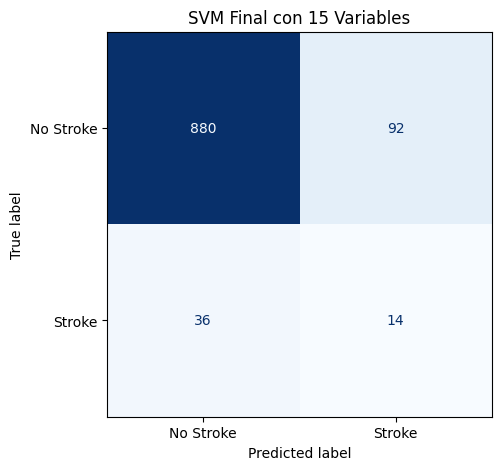

In [18]:
modelo_final = SVC(
    kernel='rbf',
    C=10,
    gamma=1,
    class_weight='balanced',
    random_state=42,
    probability=True
)

modelo_final.fit(X_train_sel, y_train)
y_pred_final = modelo_final.predict(X_val_sel)

print(classification_report(y_val, y_pred_final))

fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred_final)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke']).plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f"SVM Final con {len(selected_features)} Variables")
plt.show()

Podemos ver como mejoramos de manera significativa, aunque todavía sigue siendo un modelo peor que el lineal, ya que sigue sin predecir bien los TP y tiene una recall de solo 0.28

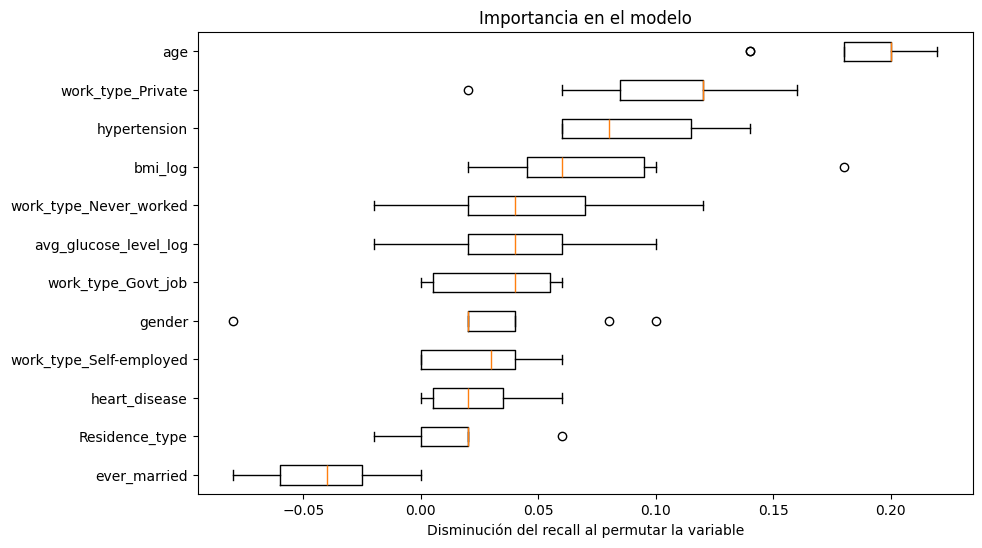

In [19]:
result = permutation_importance(
    modelo_final,
    X_val_sel,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring='recall',
    n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_train.columns[sorted_idx]
)
plt.title("Importancia en el modelo")
plt.xlabel("Disminución del recall al permutar la variable")
plt.show()

Vemos aquí de nuevo la importancia de las variables, es muy similar al modelo sin selección de características, aunque como ahora hay menos variables, las que hay son algo más importantes en comparación.

Además, como el modelo lineal era mucho mejor que el no lineal, hemos decidido entrenar este de nuevo utilizando la selección de características.

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       972
           1       0.13      0.80      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.72      0.80      1022



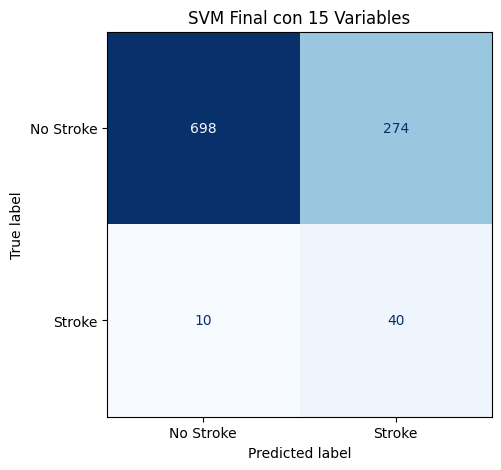

In [20]:
# modelo lineal con seleccion de caracteristicas
modelo_lineal_wrapper = SVC(
    kernel='linear',
    C=100,
    class_weight='balanced',
    random_state=42,
    probability=True
)

modelo_lineal_wrapper.fit(X_train_sel, y_train)

y_pred_final = modelo_lineal_wrapper.predict(X_val_sel)

print(classification_report(y_val, y_pred_final))

# Matriz de confusión
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred_final)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke']).plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f"SVM Final con {len(selected_features)} Variables")
plt.show()

Vemos como el modelo es idéntico al lineal con todas las variables pero usando menos, por lo que este es mejor para nuestro problema.

## *Sección III: Comparación Final*


Calculamos las figuras de mérito de todos los modelos

In [21]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
def obtener_metricas(modelo, X, y_true, nombre_modelo):
    y_pred = modelo.predict(X)

    try:
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(X)[:, 1]
        else:
            y_proba = modelo.decision_function(X)
        auc = roc_auc_score(y_true, y_proba)
    except:
        auc = 0.5

    # Calcular especificidad
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        'Modelo': nombre_modelo,
        'Recall (Sensibilidad)': recall_score(y_true, y_pred),
        'Especificidad': specificity,
        'Precision': precision_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': auc,
    }

Guardamos todas y hacemos una tabla y un histograma para compararlas

,Recall (Sensibilidad),Especificidad,Precision,F1-Score,ROC-AUC
Modelo,,,,,
Regresión logística,0.7800,0.7366,0.1322,0.2261,0.8300
SVM lineal,0.8000,0.7181,0.1274,0.2198,0.8332
SVM no lineal,0.0800,0.9506,0.0769,0.0784,0.6624
SVM lineal (Wrapper),0.8000,0.7181,0.1274,0.2198,0.8313
SVM no lineal (Wrapper),0.2800,0.9053,0.1321,0.1795,0.7024


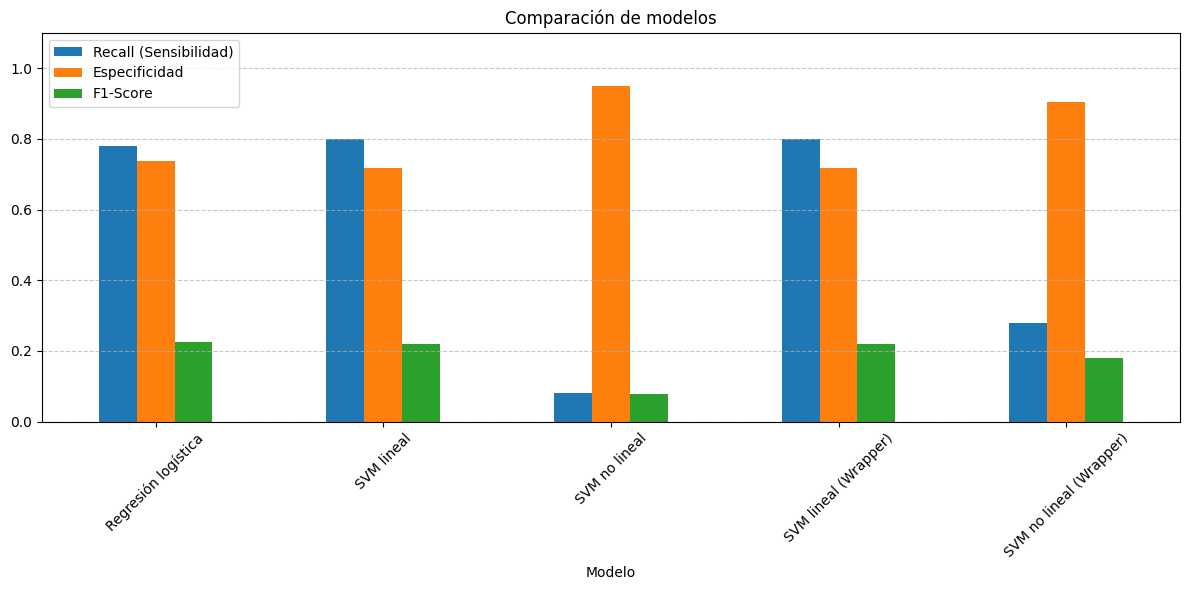

In [22]:
resultados = []
if 'log_reg' in locals():
    resultados.append(obtener_metricas(log_reg, X_val, y_val, "Regresión logística"))

if 'best_svm_linear' in locals():
    resultados.append(obtener_metricas(best_svm_linear, X_val, y_val, "SVM lineal"))

if 'best_model_nl' in locals():
    resultados.append(obtener_metricas(best_model_nl, X_val, y_val, "SVM no lineal"))

resultados.append(obtener_metricas(modelo_lineal_wrapper, X_val_sel, y_val, "SVM lineal (Wrapper)"))

if 'modelo_final' in locals():
    resultados.append(obtener_metricas(modelo_final, X_val_sel, y_val, "SVM no lineal (Wrapper)"))

df_comparativa = pd.DataFrame(resultados)
df_comparativa.set_index('Modelo', inplace=True)
display(df_comparativa.style.highlight_max(color='darkblue', axis=0).format("{:.4f}"))

df_comparativa[['Recall (Sensibilidad)', 'Especificidad', 'F1-Score']].plot(kind='bar', figsize=(12, 6), rot=45)
plt.title("Comparación de modelos")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Podemos ver comoel modelo logístico tiene el mejor equilibrio entre recall y precision (f1-score) que es lo que más nos interesa, seguido muy de cerca del modelo SVM lineal, que tiene una mayor recall pero su precision es algo menor

Por último comparamos los modelos de la tarea 2 con los de la primera tarea

Tabla comparativa (Tarea 1 + Tarea 2):


,Recall (Sensibilidad),Precision,F1-Score,ROC-AUC,Especificidad
Modelo,,,,,
Wrapper Lineal,0.8800,0.1415,0.2438,0.8421,0.7253
Regresión Logística SMOTE,0.7800,0.1322,0.2261,0.7600,0.7366
MLP 1 Capa,0.9000,0.1289,0.2256,0.8347,0.6872
Regularización (Elastic Net),0.7800,0.1300,0.2229,0.8335,0.7315
Híbrido (Selección MLP + Lineal),0.7800,0.1242,0.2143,0.8331,0.7171
MLP Profundo,0.8400,0.1183,0.2074,0.8265,0.6780
Regresión logística,0.7800,0.1322,0.2261,0.8300,0.7366
SVM lineal,0.8000,0.1274,0.2198,0.8332,0.7181
SVM no lineal,0.0800,0.0769,0.0784,0.6624,0.9506


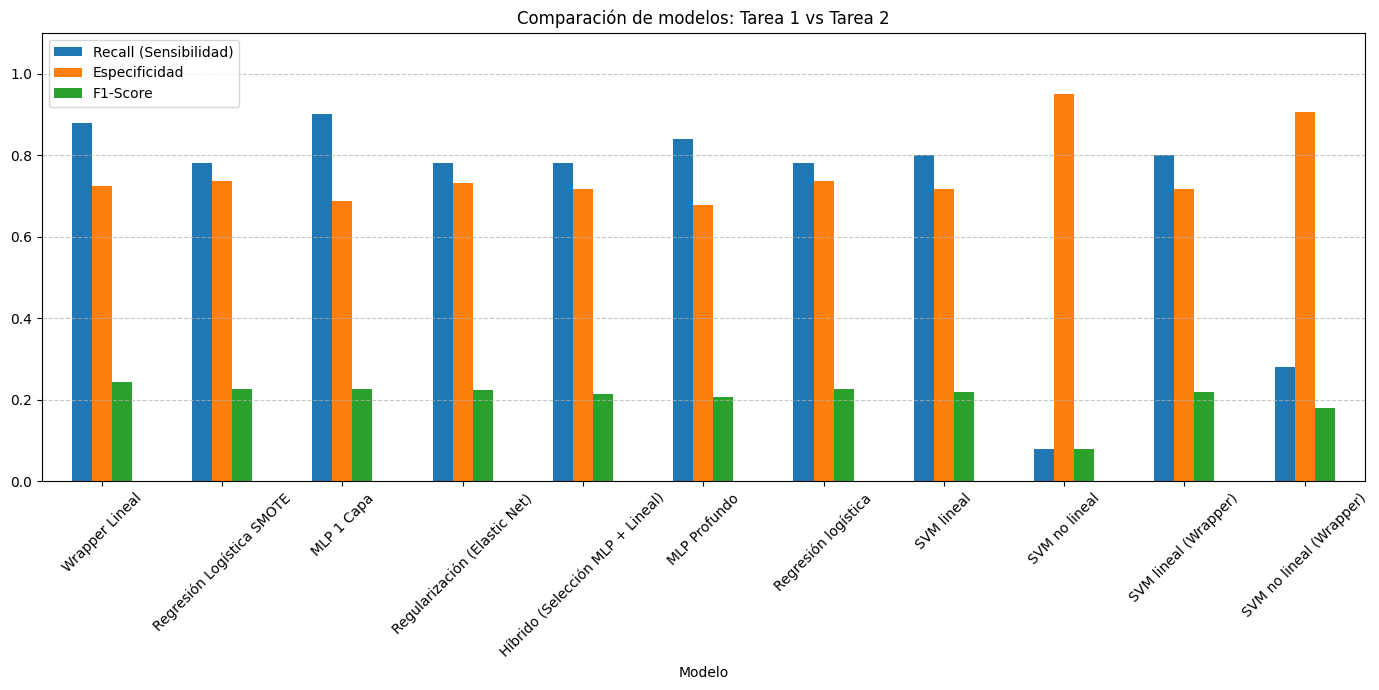

In [23]:
resultados = [
    {
        "Modelo": "Wrapper Lineal",
        "Recall (Sensibilidad)": 0.880000,
        "Precision": 0.141479,
        "F1-Score": 0.243767,
        "ROC-AUC": 0.842119,
        "Especificidad": 0.725309
    },
    {
        "Modelo": "Regresión Logística SMOTE",
        "Recall (Sensibilidad)": 0.780000,
        "Precision": 0.132203,
        "F1-Score": 0.226087,
        "ROC-AUC": 0.760000,
        "Especificidad": 0.736626
    },
    {
        "Modelo": "MLP 1 Capa",
        "Recall (Sensibilidad)": 0.900000,
        "Precision": 0.128940,
        "F1-Score": 0.225564,
        "ROC-AUC": 0.834650,
        "Especificidad": 0.687243
    },
    {
        "Modelo": "Regularización (Elastic Net)",
        "Recall (Sensibilidad)": 0.780000,
        "Precision": 0.130000,
        "F1-Score": 0.222857,
        "ROC-AUC": 0.833539,
        "Especificidad": 0.731481
    },
    {
        "Modelo": "Híbrido (Selección MLP + Lineal)",
        "Recall (Sensibilidad)": 0.780000,
        "Precision": 0.124204,
        "F1-Score": 0.214286,
        "ROC-AUC": 0.833086,
        "Especificidad": 0.717078
    },
    {
        "Modelo": "MLP Profundo",
        "Recall (Sensibilidad)": 0.840000,
        "Precision": 0.118310,
        "F1-Score": 0.207407,
        "ROC-AUC": 0.826502,
        "Especificidad": 0.677984
    }
]

if 'log_reg' in locals():
    resultados.append(obtener_metricas(log_reg, X_val, y_val, "Regresión logística"))

if 'best_svm_linear' in locals():
    resultados.append(obtener_metricas(best_svm_linear, X_val, y_val, "SVM lineal"))

if 'best_model_nl' in locals():
    resultados.append(obtener_metricas(best_model_nl, X_val, y_val, "SVM no lineal"))

if 'modelo_lineal_wrapper' in locals():
    resultados.append(obtener_metricas(modelo_lineal_wrapper, X_val_sel, y_val, "SVM lineal (Wrapper)"))

if 'modelo_final' in locals():
    resultados.append(obtener_metricas(modelo_final, X_val_sel, y_val, "SVM no lineal (Wrapper)"))

df_comparativa = pd.DataFrame(resultados)
df_comparativa.set_index('Modelo', inplace=True)

print("Tabla comparativa (Tarea 1 + Tarea 2):")
display(df_comparativa.style.highlight_max(color='darkblue', axis=0).format("{:.4f}"))

cols_to_plot = ['Recall (Sensibilidad)', 'Especificidad', 'F1-Score']
if all(col in df_comparativa.columns for col in cols_to_plot):
    df_comparativa[cols_to_plot].plot(kind='bar', figsize=(14, 7), rot=45)
    plt.title("Comparación de modelos: Tarea 1 vs Tarea 2")
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print(f"Error: Faltan columnas. Columnas disponibles: {df_comparativa.columns}")

Vemos como el modelo logístico con selección de características es infinitamente mejor que el resto de modelos y varios de los modelos más simples implementados en la práctica anterior son mejores que los de esta. En caso de tener que implementar uno sería dicho modelo

Como tenemos que escoger uno de esta práctica, cogemos el SVM lineal con selección de características. Es el modelo con mejores resultados en cuanto a f1-score que es lo que nos interesa en nuestro problema, además de no necesitar usar todas las variables.

Reentrenamos el modelo usando train+val y lo evaluamos en test para ver como rendiría en un entorno de producción

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.13      0.74      0.21        50

    accuracy                           0.73      1022
   macro avg       0.55      0.74      0.53      1022
weighted avg       0.94      0.73      0.81      1022



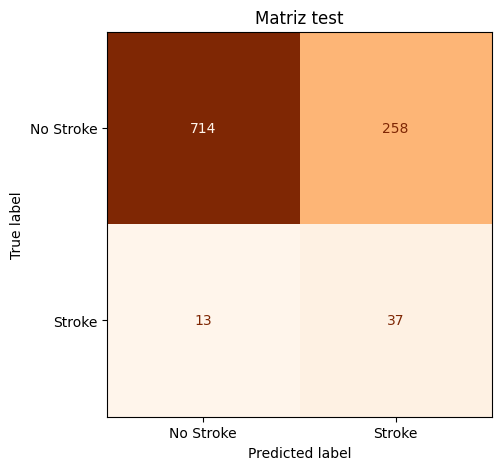

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Juntamos train y val para entrenar el mejor modelo de nuevo con todos los datos posibles
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)
X_full_sel = rfecv.transform(X_full_train)
X_test_sel = rfecv.transform(x_test)

# Reentrenamos el modelo
modelo_lineal_wrapper.fit(X_full_sel, y_full_train)

# Evaluamos en test
y_pred_test_full = modelo_lineal_wrapper.predict(X_test_sel)

print(classification_report(y_test, y_pred_test_full))

# Matriz confusion
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_test_full)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Stroke', 'Stroke'])
disp.plot(ax=ax, cmap='Oranges', colorbar=False)
ax.set_title("Matriz test")
plt.show()

Vemos que los resultados son muy similares, prediciendo el 74% de los casos positivos de forma correcta, algo que es necesario para nuestro problema. Además, en proporción los casos de FP frente a TN son muchos pero no son la mayoría por lo que el modelo no es malo para resolver nuestro problema, aunque su aplicación podría llevar a la saturación del sistema debido a la gran cantidad de pruebas extra que se tendrían que llevar a cabo a pacientes que realmente no tienen riesgo, aun así es mejor que dejar pasar casos con riesgo real.